In [1]:
import pickle
import tensorflow as tf
import numpy as np
import pprint as pp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, TimeDistributed, GRU
from keras.callbacks import TensorBoard
from keras import backend as K
from time import time 
%matplotlib inline
import livelossplot

Using TensorFlow backend.


# Misc. Functions

In [2]:
def load_in(path):
    return pickle.load(open(path,'rb'))
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot ) )
def save_model(model):
    model.save('../my_model.h5')

# Load in Data

In [3]:
filename = '../data/player_data/lebron_2018.pkl'
player = load_in(filename)
X_justloaded = player['X'][:-1]
y_justloaded = player['y'][:-1]

# Reshape Data

We are interested in exploring if the $t$-th fantasy point has dependency on the previous $l$ inputs - this will be `lookback` in code. 

LTSM and other recurrent layers, in Keras, expect a tensor in the form given by the tuple:$$(samples, timesteps, features)$$
* **samples** - number of sequences of length "time steps".
* **timesteps** - how many steps including and behind the current is important, i.e. $l + 1$ steps.
* **features** - number of feautures.

Say the number of observations in the array `X` is $76$. If we consider that the last 5 ( i.e. `lookback = 5`) to be of particular importance, then we can cosntruct inputs to reflect that. The following function will build up exactly $76 - l$ samples with $l+1$ timesteps with same number of features as `X`

In [4]:
def make_overlapped_inputs(X,y,lookback = 2,):
    out = np.zeros((X.shape[0]-lookback,lookback+1,X.shape[1]))
    for i in range(lookback,X.shape[0]):
        out[i-lookback,:,:] = X[(i-lookback):i+1,:]
    y_out = y[lookback::]
    return out,y_out

In [5]:
lookback = 2
X,y = make_overlapped_inputs(X_justloaded,y_justloaded,lookback)
print(y.shape,X.shape)

(74,) (74, 3, 95)


# Model Definiton + Compilation

In [21]:
plot_losses = livelossplot.PlotLossesKeras()
model = Sequential()
model.add(GRU(30,input_shape = (lookback+1,95), unroll=False, return_sequences=False))
model.add(GRU(12, return_sequences=False))
model.add((Dense(30)))
model.add((Dense(1)))
model.add(Activation("relu"))

# Choose the loss and optimisation scheme.
model.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mae','mse',coeff_determination])
model.summary()

ValueError: Input 0 is incompatible with layer gru_19: expected ndim=3, found ndim=2

In [15]:
train_ratio = 0.5

train_n = int(len(y)*train_ratio)

X_train = X[:train_n]
y_train = y[:train_n]
X_test = X[train_n:]
y_test = y[train_n:]

model.fit(X_train, y_train, epochs=200, batch_size=50, validation_data= (X_test, y_test),
          callbacks=[plot_losses],verbose = 0)

KeyboardInterrupt: 

37/37 [==============================] - 0s 431us/step
['loss', 'mean_absolute_error', 'mean_squared_error', 'coeff_determination']
[127.68497322701118, 9.281098752408415, 127.68497322701118, -0.06002021480251003]


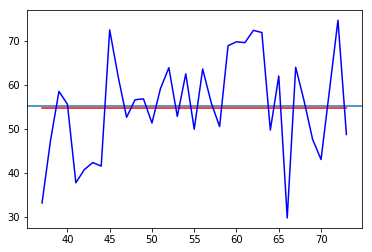

In [10]:
score = model.evaluate(X_test, y_test, batch_size=20)

print(model.metrics_names)  
print(score)    

y_pred = model.predict(X_test)
plt.plot(list(range(train_n,len(y))),y_pred,'r')
plt.axhline(y = np.average(y))
plt.plot(list(range(train_n,len(y))),y[train_n:],'b')
plt.show()